# 共享单车租车人数预测——线性回归分析

利用共享单车租车人数数据训练和测试一个模型，并对模型的性能和预测能力进行测试。

本项目将原始数据集存为csv格式，方便调用pandas做数据分析。

## 1、导入必要的工具包

In [1]:
import numpy as np  # 矩阵操作
import pandas as pd # SQL数据处理

from sklearn.metrics import r2_score  #评价回归预测模型的性能

import matplotlib.pyplot as plt   #画图
import seaborn as sns

# 图形出现在Notebook里而不是新窗口
%matplotlib inline

## 2、数据探索

### 2.1 数据读取
注：day.csv: 按天计的单车共享次数(作业只需使用该文件，故只读取该数据文件的数据)

In [2]:
# path to where the data lies 
data=pd.read_csv("day.csv")
# 通过观察前5行，了解数据每列（特征）的概况
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


### 2.2 数据基本信息

In [3]:
data.info()
# Instant:记录号  
# Dteday:日期  
# Season:季节(1=春天,2=夏天,3=秋天,4=冬天)  
# yr:年份,(0: 2011, 1:2012)  
# mnth:月份( 1 to 12)  
# holiday:是否是节假日  
# weekday:星期中的哪天,取值为 0~6   
# workingday:（是否工作日;1=工作日 (非周末和节假日);0=周末;)  
# weathersit:天气。（1:晴天,多云;2:雾天,阴天;3:小雪,小雨;4:大雨,大雪,大雾;）  
# temp:气温摄氏度  
# atemp:体感温度  
# hum:湿度  
# windspeed:风速  
# casual:非注册用户个数
# registered:注册用户个数
# cnt:租车人数  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
instant       731 non-null int64
dteday        731 non-null object
season        731 non-null int64
yr            731 non-null int64
mnth          731 non-null int64
holiday       731 non-null int64
weekday       731 non-null int64
workingday    731 non-null int64
weathersit    731 non-null int64
temp          731 non-null float64
atemp         731 non-null float64
hum           731 non-null float64
windspeed     731 non-null float64
casual        731 non-null int64
registered    731 non-null int64
cnt           731 non-null int64
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


In [4]:
### 查看是否有空值
data.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [5]:
data.shape

(731, 16)

小结：   
731个样本数据， 每个样本包含16列，1列为object型，11列数据为int64型，4列数据为float64型;   
没有缺失数据，所以无需数据填充处理;    
另外：instant(记录号)数据明显无关，可舍弃;dteday（日期）为object类型，且可用yr列做数据分割，此列作用不大，可舍弃;casual（非注册用户个数）和registered（注册用户个数）此两列为预测值，作业无要求处理，可舍弃。

### 2.3 数据处理

In [6]:
# 处理数据，instant,dteday ， casual 和 registered 数据不需要,drop掉
data = data.drop('instant', axis = 1).drop('dteday', axis = 1).drop('casual', axis = 1).drop('registered', axis = 1)
data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [7]:
# one-hot编码
# pandas.get_dummies(df,columns=['df_column_name'])
data = pd.get_dummies(data,columns=['season','mnth','weekday','weathersit'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 34 columns):
yr              731 non-null int64
holiday         731 non-null int64
workingday      731 non-null int64
temp            731 non-null float64
atemp           731 non-null float64
hum             731 non-null float64
windspeed       731 non-null float64
cnt             731 non-null int64
season_1        731 non-null uint8
season_2        731 non-null uint8
season_3        731 non-null uint8
season_4        731 non-null uint8
mnth_1          731 non-null uint8
mnth_2          731 non-null uint8
mnth_3          731 non-null uint8
mnth_4          731 non-null uint8
mnth_5          731 non-null uint8
mnth_6          731 non-null uint8
mnth_7          731 non-null uint8
mnth_8          731 non-null uint8
mnth_9          731 non-null uint8
mnth_10         731 non-null uint8
mnth_11         731 non-null uint8
mnth_12         731 non-null uint8
weekday_0       731 non-null uint8
weekday_1   

###  2.4 数据分割

In [8]:
# 根据时间划分数据，yr=0 表示 2011 年数据，作为训练样本;yr=1 表示 2012 年数据，作为测试样本;
trainning_data = data.loc[data['yr'] == 0].drop('yr', axis=1)
test_data = data.loc[data['yr'] == 1].drop('yr', axis=1)

###  2.5 目标分布分析

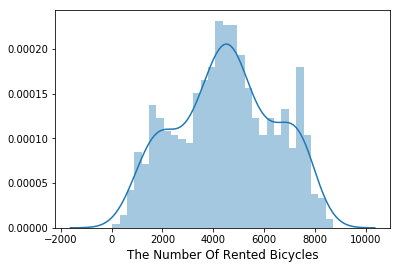

In [9]:
# 目标y（cnt）的直方图／分布
fig = plt.figure()
sns.distplot(data.cnt.values, bins=30, kde=True)#kde 核密度估计，为True会绘制一条平滑的曲线
plt.xlabel('The Number Of Rented Bicycles', fontsize=12)
plt.show()

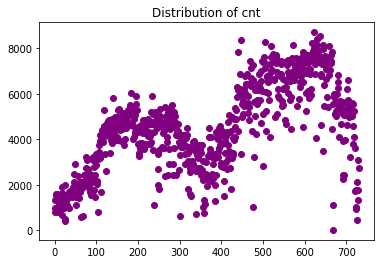

In [10]:
# 目标y散点图
plt.scatter(range(data.shape[0]), data["cnt"].values,color='purple')
plt.title("Distribution of cnt");

目标y（cnt）的散点图前半部分和后半部分有明显差异，表明数据在前后两部分中由于某些原因有明显的波动，为平衡这种差异造成的测试样本和训练样本的规律不一致的情况，现进行探索。

In [11]:
trainning_data.describe()

,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_1,season_2,season_3,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,...,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,0.027397,0.684932,0.486665,0.466835,0.643665,0.191403,3405.761644,0.246575,0.252055,0.257534,...,0.142466,0.142466,0.142466,0.142466,0.142466,0.142466,0.145205,0.619178,0.339726,0.041096
std,0.163462,0.465181,0.189596,0.168836,0.148744,0.076890,1378.753666,0.431609,0.434789,0.437876,...,0.350007,0.350007,0.350007,0.350007,0.350007,0.350007,0.352791,0.486255,0.474266,0.198785
min,0.000000,0.000000,0.059130,0.079070,0.000000,0.022392,431.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.325000,0.321954,0.538333,0.135583,2132.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.479167,0.472846,0.647500,0.186900,3740.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,0.656667,0.612379,0.742083,0.235075,4586.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,0.849167,0.840896,0.972500,0.507463,6043.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
test_data.describe()

,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_1,season_2,season_3,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,...,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,0.030055,0.683060,0.504081,0.481852,0.612166,0.189572,5599.934426,0.248634,0.251366,0.256831,...,0.144809,0.144809,0.142077,0.142077,0.142077,0.142077,0.142077,0.647541,0.336066,0.016393
std,0.170971,0.465921,0.176112,0.156756,0.134206,0.078194,1788.667868,0.432813,0.434392,0.437483,...,0.352390,0.352390,0.349607,0.349607,0.349607,0.349607,0.349607,0.478390,0.473008,0.127157
min,0.000000,0.000000,0.107500,0.101658,0.254167,0.046650,22.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.347708,0.350685,0.508125,0.133721,4369.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.514167,0.497779,0.611875,0.174750,5927.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,0.653958,0.607646,0.711146,0.231196,7011.250000,0.000000,0.750000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,0.861667,0.804913,0.925000,0.441563,8714.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


对比训练样本和测试样本的统计数据，发现X的特征在两个数据上差异不大，目标y（cnt）有明显差异

###  2.6 输入属性的直方图／分布

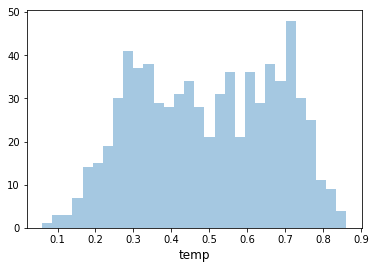

In [13]:
fig = plt.figure()
sns.distplot(data.temp.values, bins=30, kde=False)
plt.xlabel('temp', fontsize=12)
plt.show()

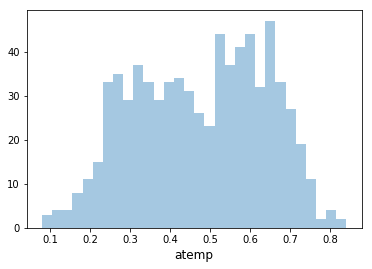

In [14]:
fig = plt.figure()
sns.distplot(data.atemp.values, bins=30, kde=False)
plt.xlabel('atemp', fontsize=12)
plt.show()

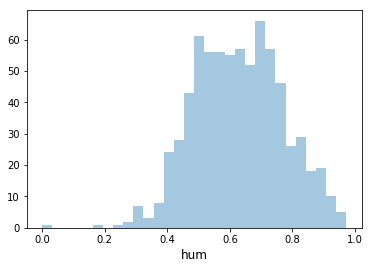

In [15]:
fig = plt.figure()
sns.distplot(data.hum.values, bins=30, kde=False)
plt.xlabel('hum', fontsize=12)
plt.show()

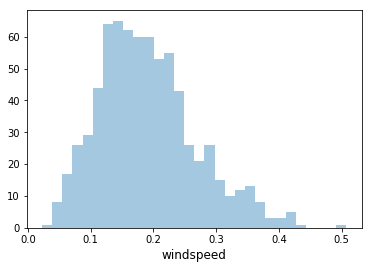

In [16]:
fig = plt.figure()
sns.distplot(data.windspeed.values, bins=30, kde=False)
plt.xlabel('windspeed', fontsize=12)
plt.show()

###  2.7 两两特征之间的相关性

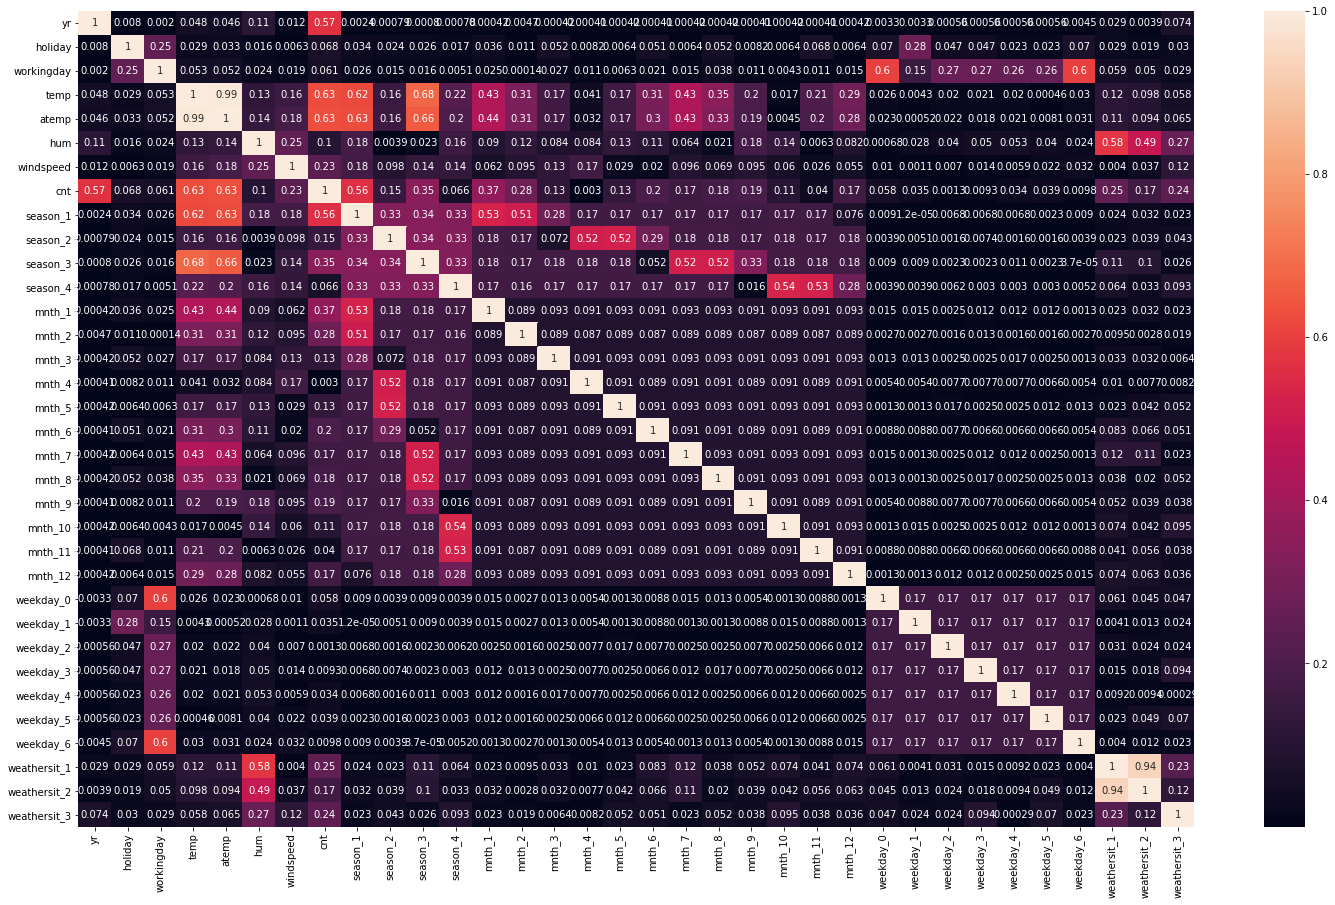

In [27]:
#get the names of all the columns
cols=data.columns 

# Calculates pearson co-efficient for all combinations，通常认为相关系数大于0.5的为强相关
data_corr = data.corr().abs()
plt.subplots(figsize=(25, 15))
sns.heatmap(data_corr,annot=True)

# Mask unimportant features
# sns.heatmap(data_corr, mask=data_corr < 1, cbar=False)
plt.show()


In [18]:
#Set the threshold to select only highly correlated attributes
threshold = 0.5
# List of pairs along with correlation above threshold
corr_list = []
#size = data.shape[1]
size = data_corr.shape[0]

#Search for the highly correlated pairs
for i in range(0, size): #for 'size' features
    for j in range(i+1,size): #avoid repetition
        if (data_corr.iloc[i,j] >= threshold and data_corr.iloc[i,j] < 1) or (data_corr.iloc[i,j] < 0 and data_corr.iloc[i,j] <= -threshold):
            corr_list.append([data_corr.iloc[i,j],i,j]) #store correlation and columns index

#Sort to show higher ones first            
s_corr_list = sorted(corr_list,key=lambda x: -abs(x[0]))

#Print correlations and column names
for v,i,j in s_corr_list:
    print ("%s and %s = %.2f" % (cols[i],cols[j],v))


temp and atemp = 0.99
weathersit_1 and weathersit_2 = 0.94
temp and season_3 = 0.68
atemp and season_3 = 0.66
atemp and cnt = 0.63
temp and cnt = 0.63
atemp and season_1 = 0.63
temp and season_1 = 0.62
workingday and weekday_0 = 0.60
workingday and weekday_6 = 0.60
hum and weathersit_1 = 0.58
yr and cnt = 0.57
cnt and season_1 = 0.56
season_4 and mnth_10 = 0.54
season_1 and mnth_1 = 0.53
season_4 and mnth_11 = 0.53
season_2 and mnth_5 = 0.52
season_3 and mnth_8 = 0.52
season_3 and mnth_7 = 0.52
season_2 and mnth_4 = 0.52
season_1 and mnth_2 = 0.51


温度和体感温度强相关，这与常识相符，如有必要可以只选用其中之一即可。

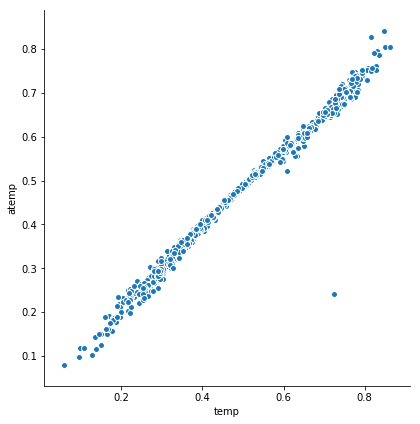

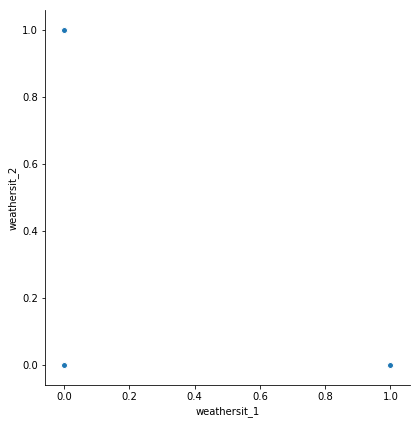

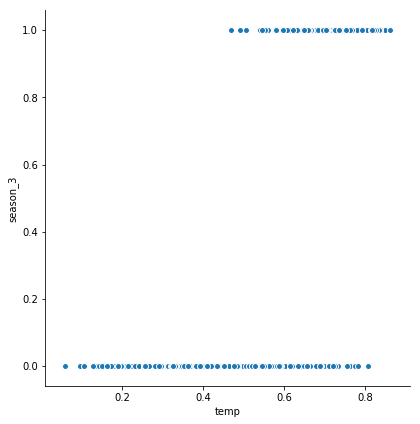

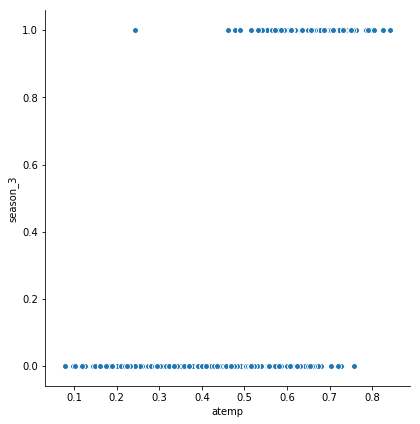

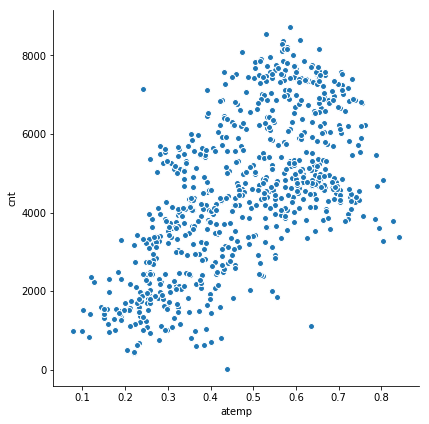

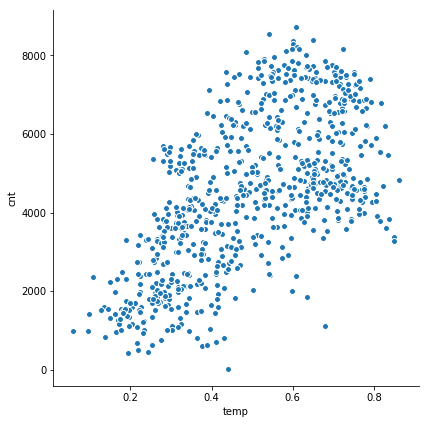

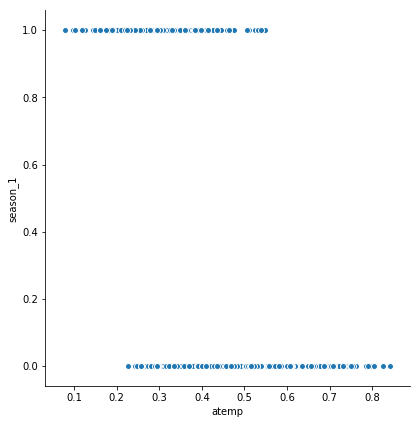

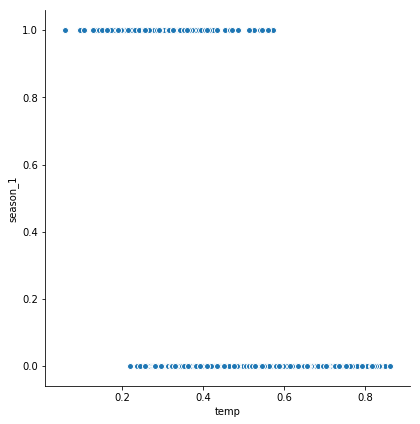

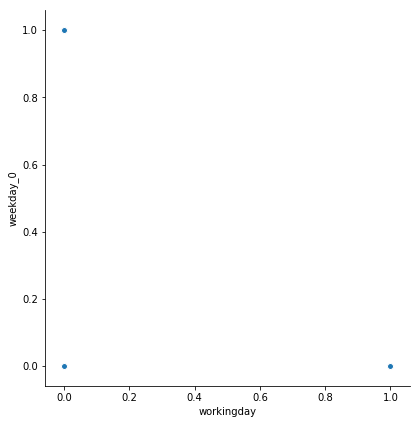

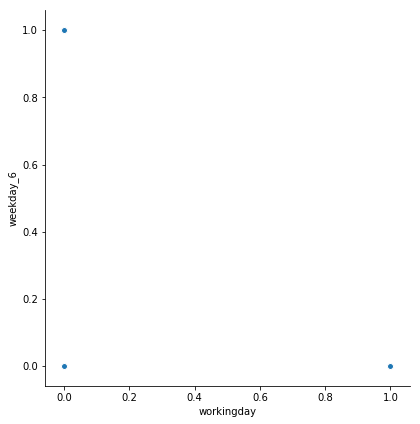

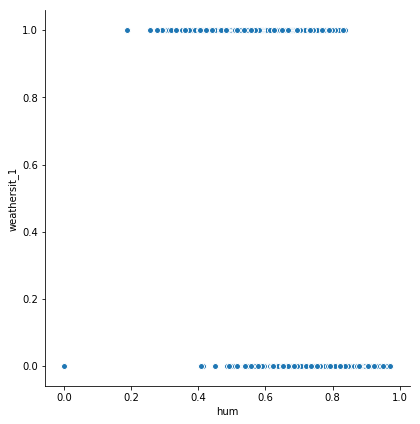

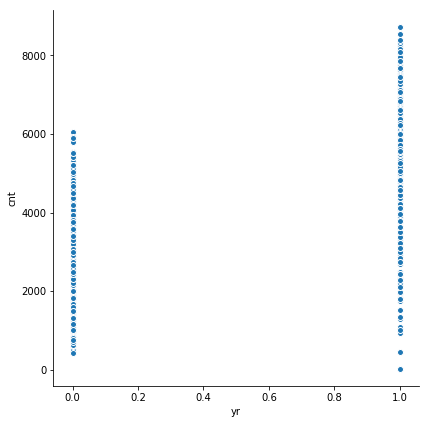

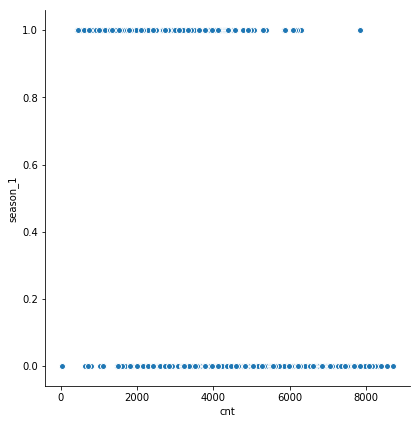

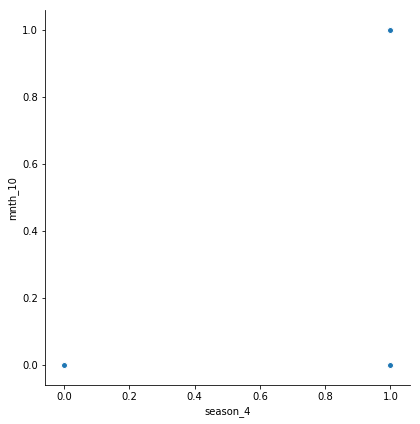

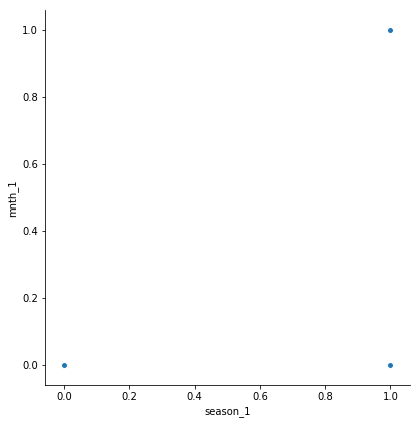

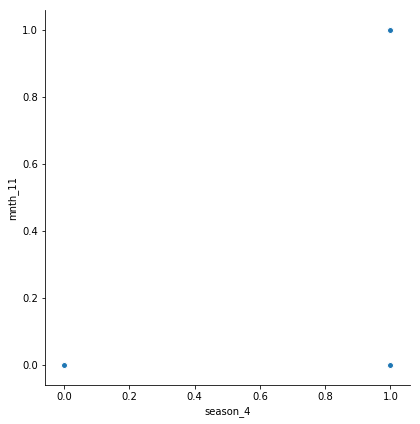

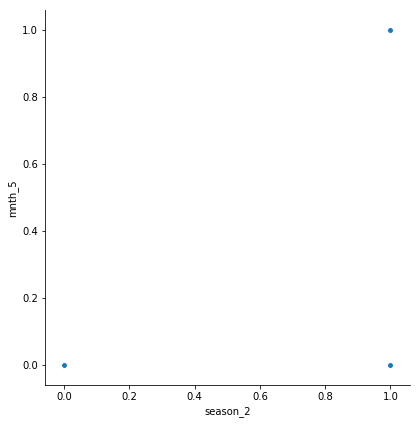

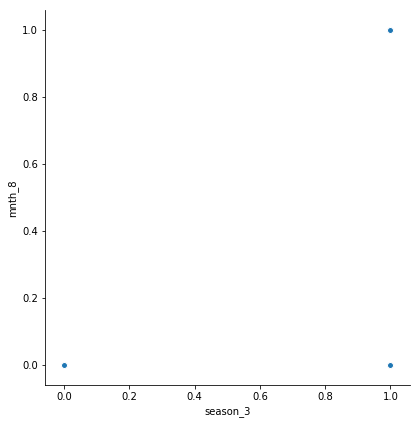

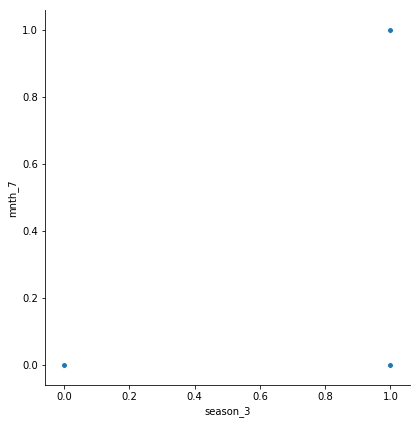

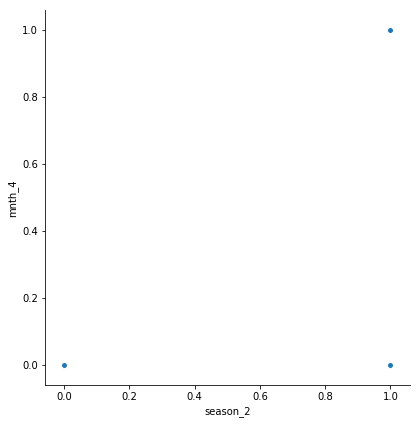

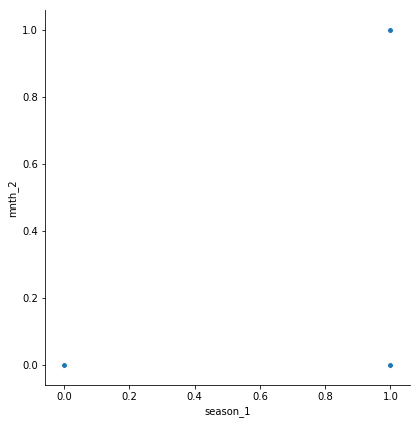

In [19]:
# Scatter plot of only the highly correlated pairs
for v,i,j in s_corr_list:
    sns.pairplot(data, size=6, x_vars=cols[i],y_vars=cols[j] )
    plt.show()

### 2.8 分离输入特征X和输出y

In [20]:
# 从原始数据中分离输入特征x和输出y
y_train = trainning_data['cnt'].values
X_train = trainning_data.drop('cnt', axis = 1)

y_test = test_data['cnt'].values
X_test = test_data.drop('cnt', axis = 1)

#用于后续显示权重系数对应的特征
columns = X_train.columns

X_train.shape

(365, 32)

### 2.9 数据标准化：

In [21]:
# 数据标准化
from sklearn.preprocessing import StandardScaler

# 分别初始化对特征和目标值的标准化器
ss_X = StandardScaler()
ss_y = StandardScaler()
# 分别对训练和测试数据的特征以及目标值进行标准化处理
X_train = ss_X.fit_transform(X_train)
X_test = ss_X.transform(X_test)

#对y做标准化不是必须
#对y标准化的好处是不同问题的w差异不太大，同时正则参数的范围也有限
y_train = ss_y.fit_transform(y_train.reshape(-1, 1))
y_test = ss_y.transform(y_test.reshape(-1, 1))

# 计算两个集上y均值的差值，用于后续修正模型
y_offset = y_test.mean() - y_train.mean()



/root/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/root/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/root/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## 3、正则化的线性回归（L2正则 --> 岭回归)

In [22]:
#岭回归／L2正则
#class sklearn.linear_model.RidgeCV(alphas=(0.1, 1.0, 10.0), fit_intercept=True, 
#                                  normalize=False, scoring=None, cv=None, gcv_mode=None, 
#                                  store_cv_values=False)
from sklearn.linear_model import  RidgeCV

#设置超参数（正则参数）范围
alphas = [ 0.01, 0.1, 1, 10,100]

#生成一个RidgeCV实例
ridge = RidgeCV(alphas=alphas, store_cv_values=True)  

#模型训练
ridge.fit(X_train, y_train)    

#预测
y_test_pred_ridge = ridge.predict(X_test)+ y_offset
y_train_pred_ridge = ridge.predict(X_train)


# 评估，使用r2_score评价模型在测试集和训练集上的性能
print('The r2 score of RidgeCV on test is', r2_score(y_test, y_test_pred_ridge))
print('The r2 score of RidgeCV on train is', r2_score(y_train, y_train_pred_ridge))

The r2 score of RidgeCV on test is 0.6667510129834557
The r2 score of RidgeCV on train is 0.8402009836272226


### 可视化

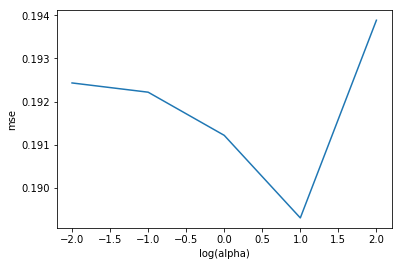

alpha is: 10.0


,columns,coef_ridge
2,temp,[0.2273348396576823]
3,atemp,[0.18260196430381953]
14,mnth_5,[0.1640185925608888]
9,season_4,[0.15149287406348008]
15,mnth_6,[0.1151674589235777]
29,weathersit_1,[0.09155441911716575]
18,mnth_9,[0.08439145780949024]
8,season_3,[0.07429145923966472]
19,mnth_10,[0.05294852799630308]
28,weekday_6,[0.01717147372970134]


In [23]:
mse_mean = np.mean(ridge.cv_values_, axis = 0)
plt.plot(np.log10(alphas), mse_mean.reshape(len(alphas),1)) 

#这是为了标出最佳参数的位置，不是必须
#plt.plot(np.log10(ridge.alpha_)*np.ones(3), [0.28, 0.29, 0.30])

plt.xlabel('log(alpha)')
plt.ylabel('mse')
plt.show()

print ('alpha is:', ridge.alpha_)

# 看看各特征的权重系数，系数的绝对值大小可视为该特征的重要性
fs = pd.DataFrame({"columns":list(columns), "coef_ridge":list((ridge.coef_.T))})
fs.sort_values(by=['coef_ridge'],ascending=False)

## 3、正则化的线性回归（L1正则 --> Lasso）

In [24]:
#### Lasso／L1正则
# class sklearn.linear_model.LassoCV(eps=0.001, n_alphas=100, alphas=None, fit_intercept=True, 
#                                    normalize=False, precompute=’auto’, max_iter=1000, 
#                                    tol=0.0001, copy_X=True, cv=None, verbose=False, n_jobs=1,
#                                    positive=False, random_state=None, selection=’cyclic’)
from sklearn.linear_model import LassoCV

#设置超参数搜索范围
alphas = [ 0.01, 0.1, 1, 10,100]

#生成一个LassoCV实例
lasso = LassoCV(alphas=alphas)  
#lasso = LassoCV()  

#训练（内含CV）
lasso.fit(X_train, y_train)  

#测试
y_test_pred_lasso = lasso.predict(X_test)+y_offset
y_train_pred_lasso = lasso.predict(X_train)


# 评估，使用r2_score评价模型在测试集和训练集上的性能
print('The r2 score of LassoCV on test is', r2_score(y_test, y_test_pred_lasso))
print('The r2 score of LassoCV on train is', r2_score(y_train, y_train_pred_lasso))

The r2 score of LassoCV on test is 0.664188376056656
The r2 score of LassoCV on train is 0.8371946492006284


/root/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


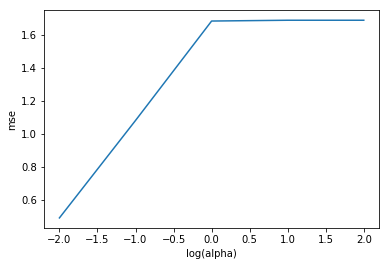

alpha is: 0.01


,columns,coef_ridge,coef_lasso
2,temp,[0.2273348396576823],0.456552
3,atemp,[0.18260196430381953],0.000000
14,mnth_5,[0.1640185925608888],0.134842
9,season_4,[0.15149287406348008],0.078399
15,mnth_6,[0.1151674589235777],0.090850
29,weathersit_1,[0.09155441911716575],0.104142
18,mnth_9,[0.08439145780949024],0.083093
8,season_3,[0.07429145923966472],0.007089
19,mnth_10,[0.05294852799630308],0.071557
28,weekday_6,[0.01717147372970134],0.001942


In [25]:
mses = np.mean(lasso.mse_path_, axis = 1)
plt.plot(np.log10(lasso.alphas_), mses) 
#plt.plot(np.log10(lasso.alphas_)*np.ones(3), [0.3, 0.4, 1.0])
plt.xlabel('log(alpha)')
plt.ylabel('mse')
plt.show()    
            
print('alpha is:', lasso.alpha_)

# 看看各特征的权重系数，系数的绝对值大小可视为该特征的重要性
fs = pd.DataFrame({"columns":list(columns), "coef_ridge":list((ridge.coef_.T)), "coef_lasso":list((lasso.coef_.T))})
fs.sort_values(by=['coef_ridge'],ascending=False)